In [2]:
from numba import jit, njit
import kwant
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
import kwant.kpm


import scipy

import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace

import cmath

from qutip import *
from joblib import Parallel, delayed

from scipy.ndimage import gaussian_filter

import pandas as pd

/opt/anaconda3/lib/python3.12/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [3]:
s_ = sigmam()

Delta = 0
Om = .222
gam = .044
deph = .044

Nd = 600
arr_Delta = np.linspace(-3,3,Nd)
arr_pop = np.zeros(Nd)
arr_pop2 = np.zeros(Nd)

for nD, Delta in enumerate(arr_Delta):
    H = Delta * s_.dag()*s_ + Om * ( s_ + s_.dag() )
    c_jumps = [gam**.5*s_, deph**.5*s_.dag()*s_]
    rhoss = steadystate(H, c_jumps)
    arr_pop[nD] = expect(s_.dag()*s_, rhoss)
    
    c_jumps = [gam**.5*s_, (10*deph)**.5*s_.dag()*s_]
    rhoss2 = steadystate(H, c_jumps)
    arr_pop2[nD] = expect(s_.dag()*s_, rhoss2)
    

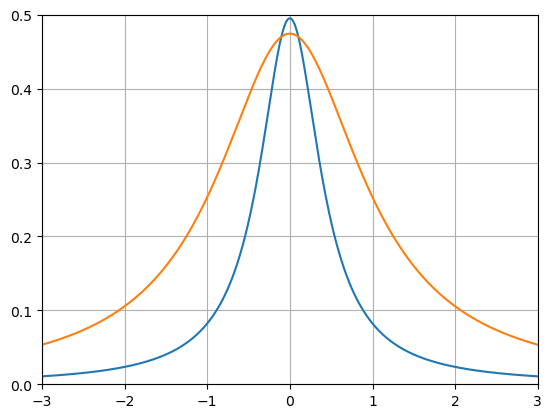

In [4]:
plt.plot(arr_Delta, arr_pop)
plt.plot(arr_Delta, arr_pop2)

plt.ylim(0,.5)
plt.xlim(-3,3)
plt.grid()

In [194]:
Nd = 1000
#arr_deph = np.linspace(0.001,30,Nd)
arr_deph = np.logspace(-4,2,Nd)
arr_pop_deph = np.zeros(Nd)
arr_pop_deph_OM = np.zeros(Nd)
arr_pop_gam = np.zeros(Nd)
Delta = .1
Om = .0222
gam = .044

for nD, deph in enumerate(arr_deph):
    H = Delta * s_.dag()*s_ + Om * ( s_ + s_.dag() )
    c_jumps = [gam**.5*s_, deph**.5*s_.dag()*s_]
    rhoss = steadystate(H, c_jumps)
    arr_pop_deph[nD] = expect(s_.dag()*s_, rhoss)
    
    H = Delta * s_.dag()*s_ + Om * ( s_ + s_.dag() )
    c_jumps = [ (gam+deph)**.5*s_ ]
    rhoss = steadystate(H, c_jumps)
    arr_pop_gam[nD] = expect(s_.dag()*s_, rhoss)
    
    H = Delta * s_.dag()*s_ + Om * (1. - (deph/np.amax(arr_deph)) )**4. * ( s_ + s_.dag() )
    c_jumps = [gam**.5*s_, deph**.5*s_.dag()*s_]
    rhoss = steadystate(H, c_jumps)
    arr_pop_deph_OM[nD] = expect(s_.dag()*s_, rhoss)
    

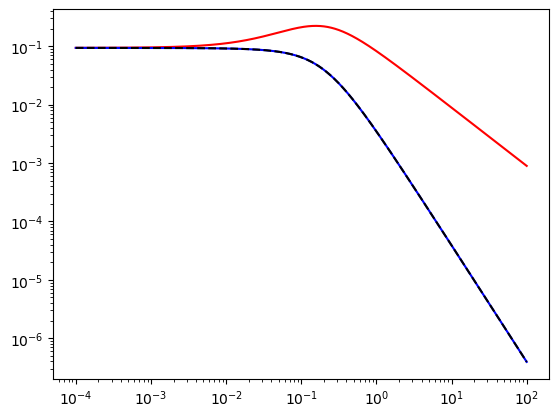

In [195]:
plt.plot(arr_deph, (2*arr_pop_deph/(1-2*arr_pop_deph)), color='red' )
plt.plot(arr_deph, (2*arr_pop_gam/(1-2*arr_pop_gam)), color='blue' )
plt.plot(arr_deph, 8*(Om**2/( (arr_deph+gam)**2. + 4*Delta**2 )) , color='black', linestyle='--' )
plt.yscale('log')
plt.xscale('log')


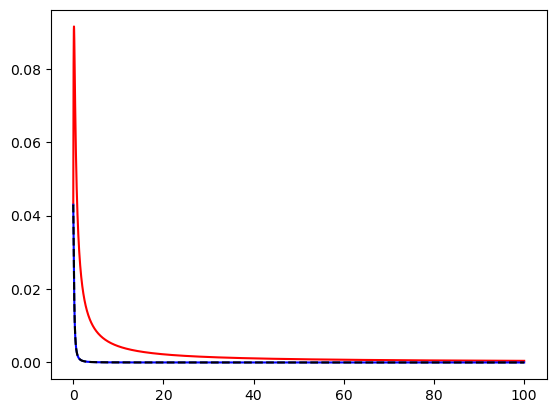

In [196]:
Sat = 8*(Om**2/( (arr_deph+gam)**2. + 4*Delta**2 ))
plt.plot(arr_deph, arr_pop_deph, color='red' )
plt.plot(arr_deph, arr_pop_gam, color='blue' )
plt.plot(arr_deph, .5*Sat/(1+Sat) , color='black', linestyle='--' )


Text(0.5, 0, 'FWHM')

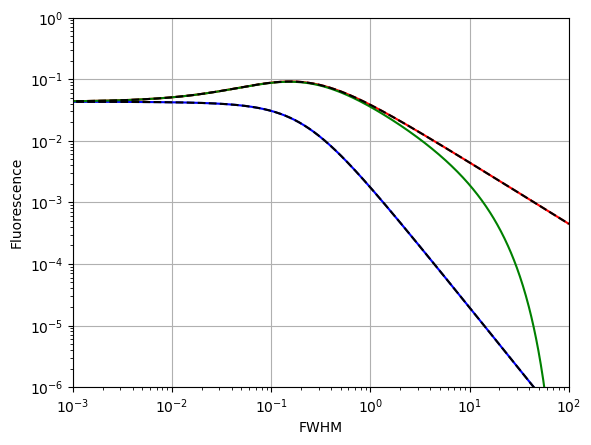

In [197]:
Sat = 8*(Om**2/( (arr_deph+gam)**2. + 4*Delta**2 ))

S_d = 8*Om**2*(arr_deph+gam)/(gam*(4*Delta**2+(arr_deph+gam)**2))
fluo_d = .5*S_d/(1+S_d)
#plt.plot(arr_pop_deph, arr_deph,  color='red' )
#plt.plot(arr_pop_gam, arr_deph,  color='blue' )
#plt.plot(arr_pop_deph_OM, arr_deph,  color='green' )
#plt.plot(.5*Sat/(1+Sat) , arr_deph,  color='black', linestyle='--' )
plt.plot( arr_deph, arr_pop_deph,  color='red' )
plt.plot( arr_deph, arr_pop_gam,  color='blue' )
plt.plot( arr_deph, arr_pop_deph_OM,  color='green' )
plt.plot( arr_deph, .5*Sat/(1+Sat) ,  color='black', linestyle='--' )
plt.plot( arr_deph, fluo_d ,  color='black', linestyle='--' )


plt.yscale('log')
plt.xscale('log')

plt.xlim(1e-3,1e2)
plt.ylim(1e-6,1e0)

plt.grid()

plt.ylabel("Fluorescence")
plt.xlabel("FWHM")

In [16]:
Nd = 600
arr_Om = np.linspace(0.01,1,Nd)
arr_pop_Om = np.zeros(Nd)
Delta = 0
deph = .044

for nD, Om in enumerate(arr_Om):
    H = Delta * s_.dag()*s_ + Om * ( s_ + s_.dag() )
    c_jumps = [gam**.5*s_, deph**.5*s_.dag()*s_]
    rhoss = steadystate(H, c_jumps)
    arr_pop_Om[nD] = expect(s_.dag()*s_, rhoss)

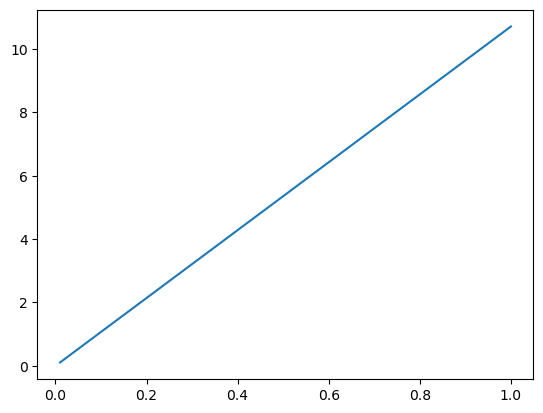

In [99]:
plt.plot( arr_Om, (2*arr_pop_Om/(1.-2*arr_pop_Om) * gam*(gam+deph/2.)**1/4)**.5 )